# Load benchmark files

In [144]:
import json

# Load a file and store values
class benchmark_file:

    def __init__(self, filename, path):
        split = filename.replace(".json", "").split("_")
        self.run = int(split[0][3])
        self.model_name = "yolo" if split[1] == "FrameDnnOnnxYolo" else "maskrcnn"
        self.experiment_name = split[2]
        self.video_name = filename.replace(".json", "")

        data = open(path, "r")
        json_data = json.load(data)
        self.object_detection = json_data['object_detection']
        self.latency = {}
        self.latency['total'] = json_data['Latencies']['total']
        self.latency['model_latency'] = json_data['Latencies']['model']
        self.latency['bgs_latency'] = json_data['Latencies']['bgs']
        self.latency['decode_latency'] = json_data['Latencies']['decode']
        self.latency['pre_process_latency'] = json_data['Latencies']['pre_process']
        self.latency['post_process_latency'] = json_data['Latencies']['post_process']
        # self.latency['onnx_pre_process_latency'] = json_data['Latencies']['onnx_pre_process']
        # self.latency['onnx_process_latency'] = json_data['Latencies']['onnx_process']
        # self.latency['onnx_post_process_latency'] = json_data['Latencies']['onnx_post_process']

        # print(f"Discovered run {self.run} for {self.model_name} and experiment {self.experiment_name}")

In [145]:
def average_list(run_list, latency_name):
    all_lists = []

    for run in run_list:
        all_lists.append(run.latency[latency_name])

    return [sum(x)/len(run_list) for x in zip(*all_lists)]

    
class experiment_run:

    def __init__(self, benchmark_files, experiment_name, model_name):
        self.experiment_name = experiment_name
        self.model_name = model_name

        runs = []

        for obj in benchmark_files:
            if obj.experiment_name == experiment_name and obj.model_name == model_name:
                runs.append(obj)

        self.latency = {}
        self.latency['total'] = average_list(runs, 'total')
        self.latency['model_latency'] = average_list(runs, 'model_latency')
        self.latency['bgs_latency'] = average_list(runs, 'bgs_latency')
        self.latency['decode_latency'] = average_list(runs, 'decode_latency')
        self.latency['pre_process_latency'] = average_list(runs, 'pre_process_latency')
        self.latency['post_process_latency'] = average_list(runs, 'post_process_latency')
        

In [146]:
import os
import json

BENCHMARK_FOLDER = "./case1"

def discover_benchmarks():
    benchmark_files = []

    for files in os.listdir(BENCHMARK_FOLDER):
        file_path = os.path.join(BENCHMARK_FOLDER, files)
        if "json" not in files:
            continue

        benchmark_data = benchmark_file(files, file_path)
        benchmark_files.append(benchmark_data)

    return benchmark_files


benchmarks = discover_benchmarks()

# Load actuals files

In [147]:
class actuals_data:

    def __init__(self, filename, file_path):
        split = filename.replace(".json", "").split("_")

        data = open(file_path, "r")
        json_data = json.load(data)

        self.experiment_name = split[0]
        self.fps = 30

        self.object_distribution = []
        self.object_count = []

        for value in json_data['object_distribution']:
            for i in range(self.fps):
                self.object_distribution.append(value)
                self.object_count.append(len(value))

        # print(self.object_count)
        


In [148]:
import os
import json

ACTUALS_FOLDER = "./actuals"

def discover_actuals():
    actuals_files = []

    for files in os.listdir(ACTUALS_FOLDER):
        file_path = os.path.join(ACTUALS_FOLDER, files)
        if "json" not in files:
            continue

        # print(len(json_data['object_distribution']))

        data = actuals_data(files, file_path)
        actuals_files.append(data)

    return actuals_files


actuals = discover_actuals()

In [149]:
class experiment:

    def __init__(self, benchmark_files, actual_files, experiment_name):
        self.experiment_name = experiment_name
        self.experiment = {}
        self.experiment["yolo"] = experiment_run(benchmark_files, experiment_name, "yolo")
        self.experiment["maskrcnn"] = experiment_run(benchmark_files, experiment_name, "maskrcnn")

        self.actual = None
        for obj in actual_files:
            if obj.experiment_name == experiment_name:
                self.actual = obj

In [150]:
nobjects_experiment = experiment(benchmarks, actuals, "nobjects")
obj1_experiment = experiment(benchmarks, actuals, "obj1")
obj4_experiment = experiment(benchmarks, actuals, "obj4")
obj9_experiment = experiment(benchmarks, actuals, "obj9")
obj4_9_experiment = experiment(benchmarks, actuals, "obj4-9")

# Plot graphs for Experiment 1

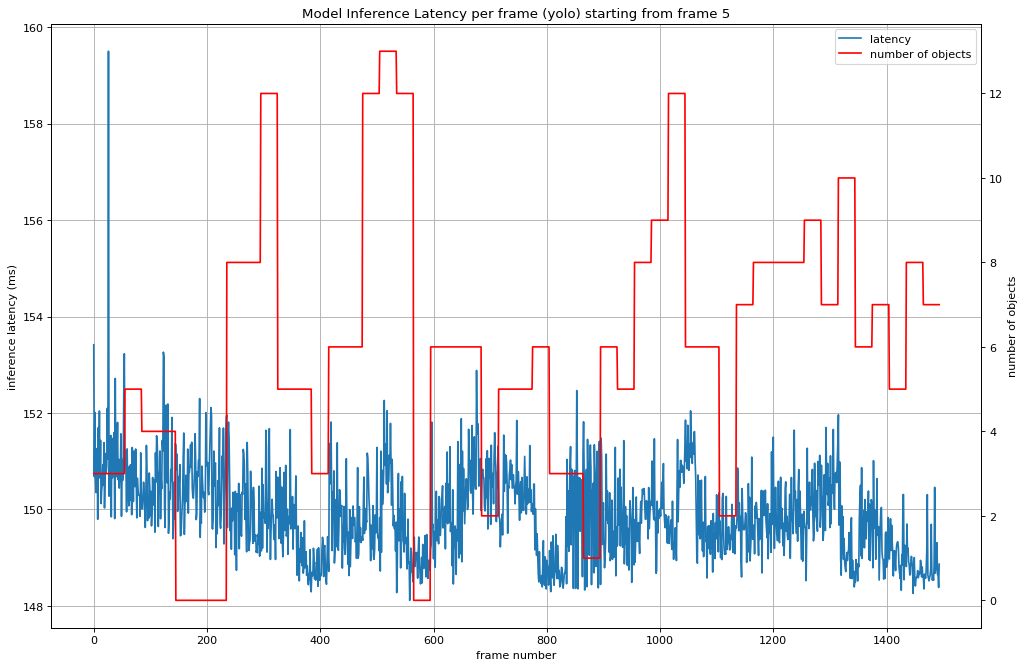

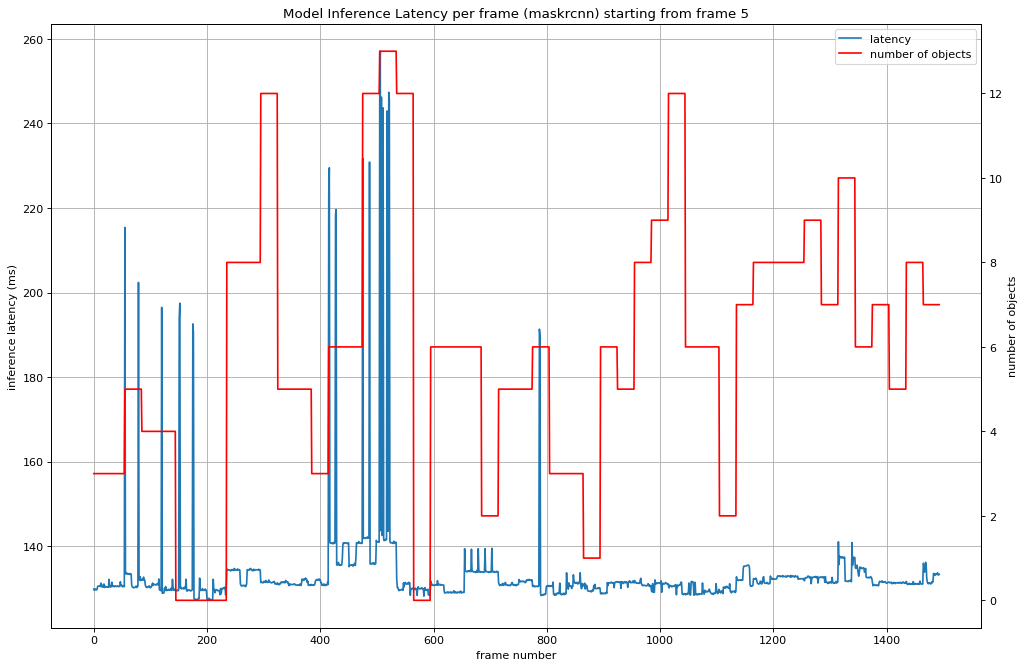

In [151]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

FRAMES_TO_SKIP = 5

def plot_experiment_1(model_name):
    
    latency = nobjects_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    frame_no = [i for i in range(len(latency))]
    nobjects = nobjects_experiment.actual.object_count[FRAMES_TO_SKIP:1499]
    fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

  
    l1 = ax1.plot(frame_no, latency, '-', label = "latency")
    ax2 = ax1.twinx()
    l2 = ax2.plot(frame_no, nobjects, '-r', label = "number of objects")
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    # added these three lines
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    ax1.set_xlabel('frame number')
    ax1.set_ylabel('inference latency (ms)')
    ax2.set_ylabel('number of objects')

    
    plt.title(f"Model Inference Latency per frame ({model_name}) starting from frame 5")
    ax1.grid()
    plt.savefig(f"experiment1_{model_name}.png")
    plt.show()

plot_experiment_1("yolo")
plot_experiment_1("maskrcnn")

# Plots for Experiment 2

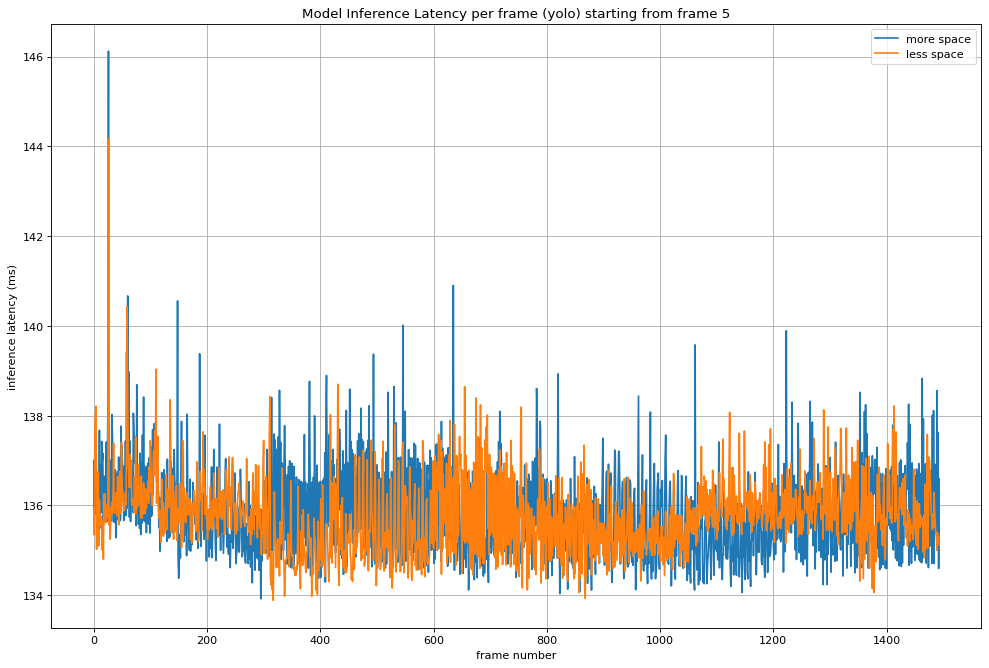

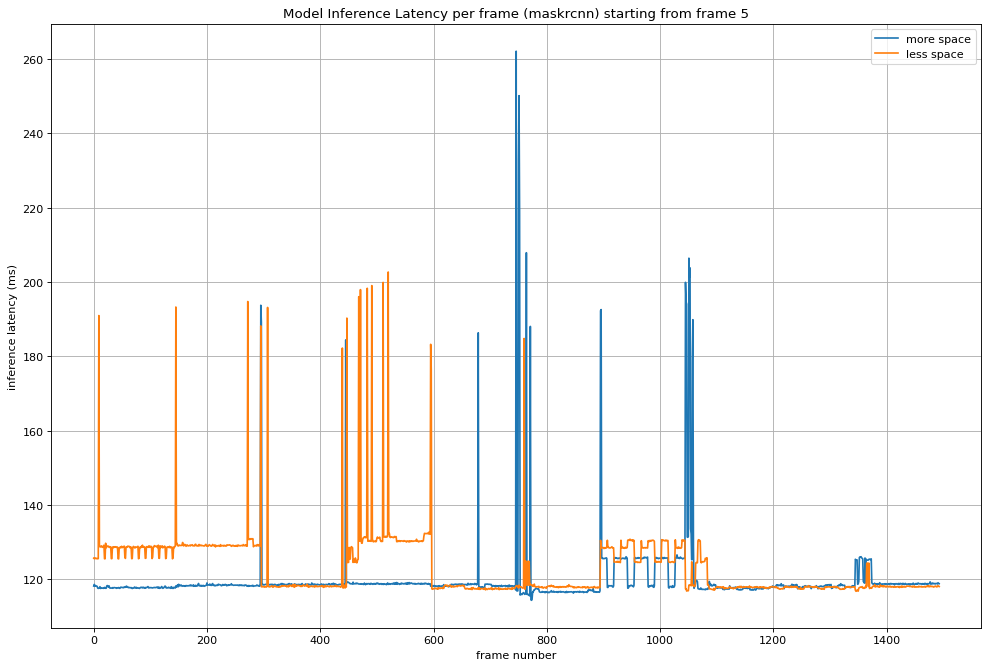

In [152]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

FRAMES_TO_SKIP = 5

def plot_experiment_2(model_name):
    
    latency_n4 = obj4_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    latency_n49 = obj4_9_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    frame_no = [i for i in range(len(latency_n4))]
    fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

  
    l1 = ax1.plot(frame_no, latency_n4, '-', label = "more space")
    l2 = ax1.plot(frame_no, latency_n49, '-', label = "less space")

    # added these three lines
    lns = l1+l2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    ax1.set_xlabel('frame number')
    ax1.set_ylabel('inference latency (ms)')
    
    plt.title(f"Model Inference Latency per frame ({model_name}) starting from frame 5")
    ax1.grid()
    plt.savefig(f"experiment2_{model_name}.png")
    plt.show()

plot_experiment_2("yolo")
plot_experiment_2("maskrcnn")

# Plots for Experiment 3

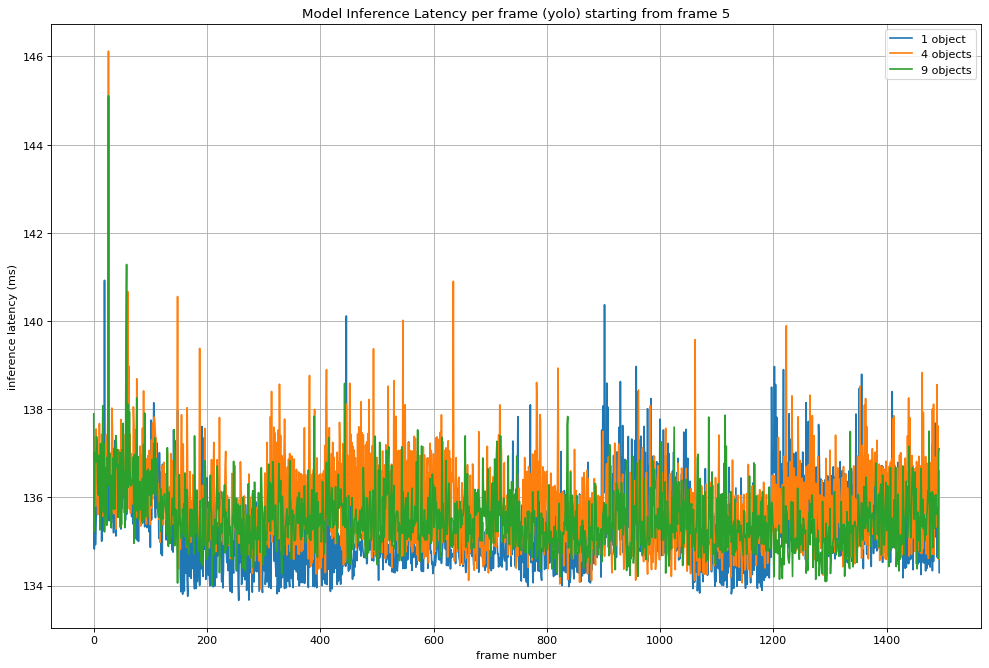

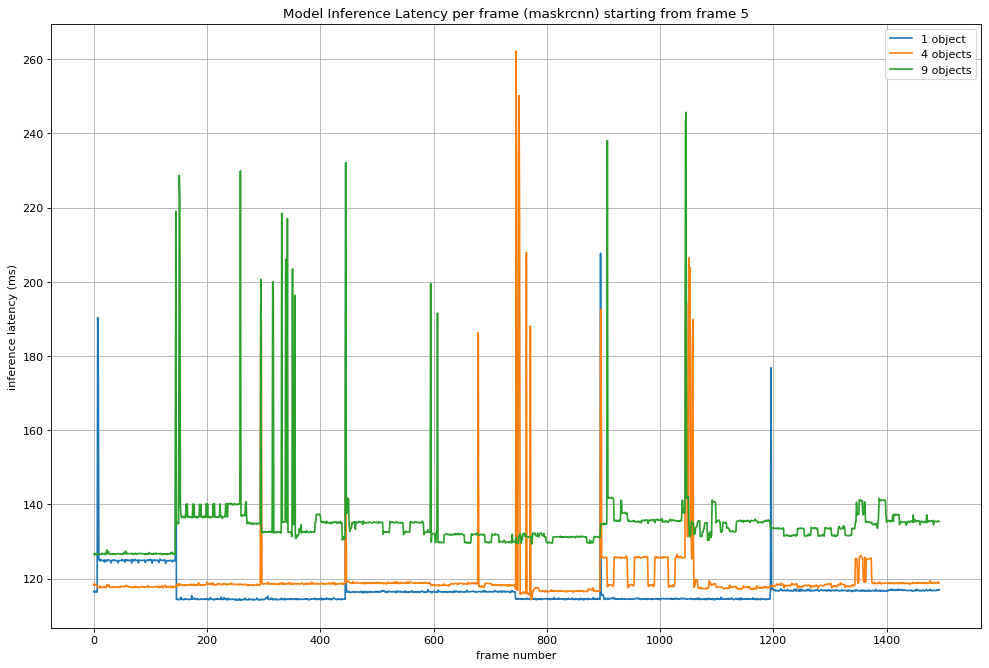

In [153]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

FRAMES_TO_SKIP = 5

def plot_experiment_3(model_name):
    
    latency_n1 = obj1_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    latency_n4 = obj4_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    latency_n9 = obj9_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    frame_no = [i for i in range(len(latency_n1))]
    fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

  
    l1 = ax1.plot(frame_no, latency_n1, '-', label = "1 object")
    l2 = ax1.plot(frame_no, latency_n4, '-', label = "4 objects")
    l3 = ax1.plot(frame_no, latency_n9, '-', label = "9 objects")
    # added these three lines
    lns = l1+l2+l3
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    ax1.set_xlabel('frame number')
    ax1.set_ylabel('inference latency (ms)')
    
    plt.title(f"Model Inference Latency per frame ({model_name}) starting from frame 5")
    ax1.grid()
    plt.savefig(f"experiment3_{model_name}.png")
    plt.show()

plot_experiment_3("yolo")
plot_experiment_3("maskrcnn")

# Interesting Phenomena

While models such as Yolo do not depend on number of objects in a frame, the actual inference latency does depend on number of objects since post processing step would could be doing tasks that depends on the number of objects

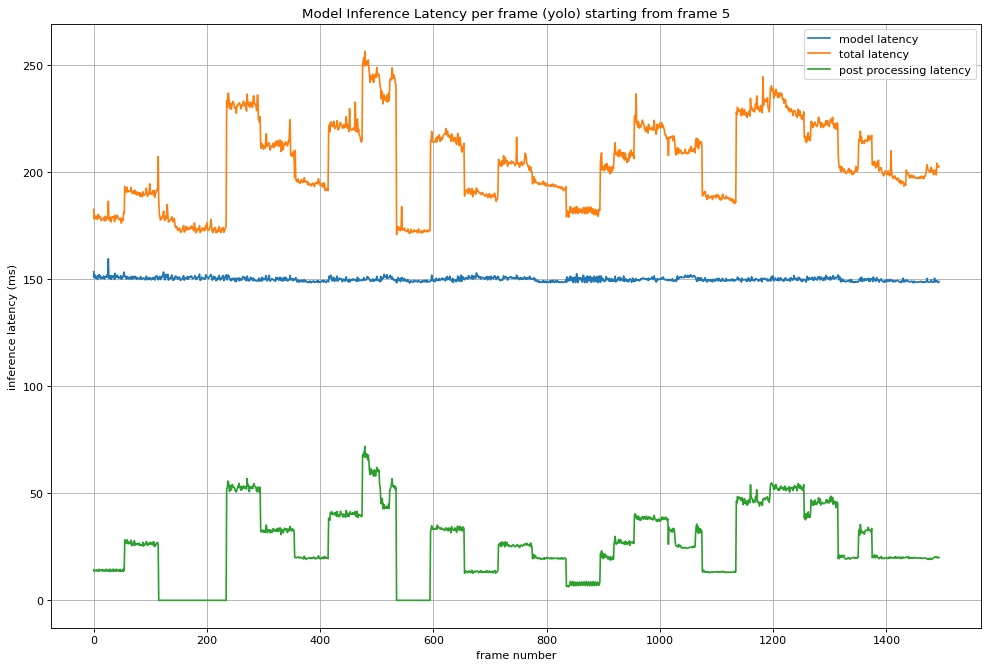

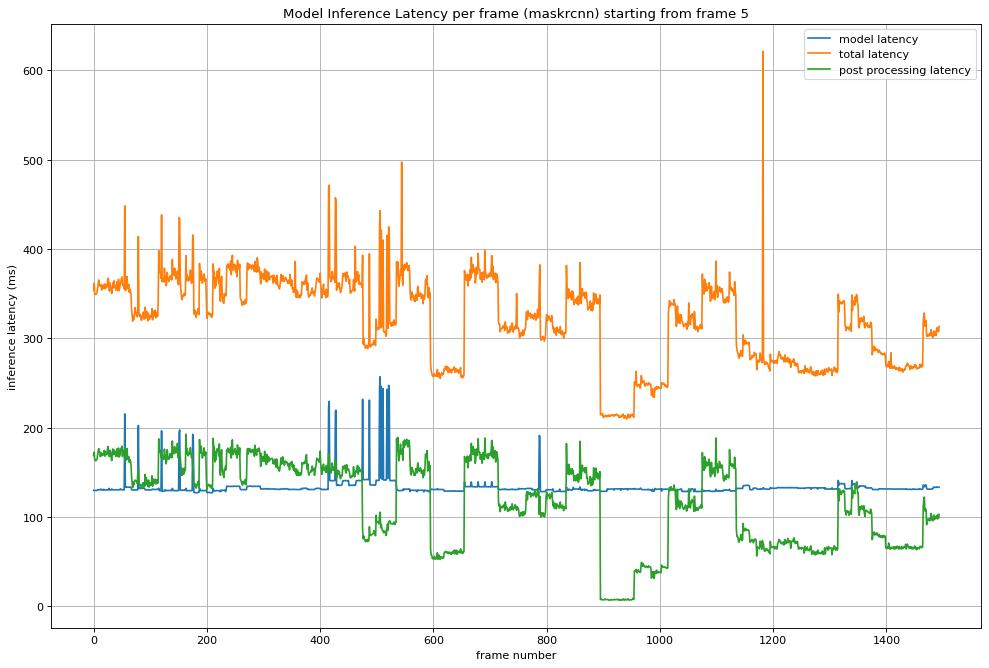

In [154]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.ticker import MaxNLocator

FRAMES_TO_SKIP = 5

def plot_phenomena(model_name):
    
    latency_model = nobjects_experiment.experiment[model_name].latency['model_latency'][FRAMES_TO_SKIP:]
    latency_processing = nobjects_experiment.experiment[model_name].latency['post_process_latency'][FRAMES_TO_SKIP:]
    latency_total = nobjects_experiment.experiment[model_name].latency['total'][FRAMES_TO_SKIP:]
    frame_no = [i for i in range(len(latency_model))]
    nobjects = nobjects_experiment.actual.object_count[FRAMES_TO_SKIP:1499]
    fig, ax1 = plt.subplots(figsize=(15, 10), dpi=80)

  
    l1 = ax1.plot(frame_no, latency_model, '-', label = "model latency")
    l3 = ax1.plot(frame_no, latency_total, '-', label = "total latency")
    l4 = ax1.plot(frame_no, latency_processing, '-', label = "post processing latency")
    # ax2 = ax1.twinx()
    # l2 = ax2.plot(frame_no, nobjects, '-r', label = "number of objects")
    # ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    # added these three lines
    lns = l1+l3+l4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc=0)

    ax1.set_xlabel('frame number')
    ax1.set_ylabel('inference latency (ms)')
    # ax2.set_ylabel('number of objects')
    
    plt.title(f"Model Inference Latency per frame ({model_name}) starting from frame 5")
    ax1.grid()
    plt.savefig(f"phenomena_{model_name}.png")
    plt.show()

plot_phenomena("yolo")
plot_phenomena("maskrcnn")